<a href="https://colab.research.google.com/github/RylieWeaver9/Competitions/blob/main/5C_Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Writing

The following is the colab notebook from the 5C Datathon at Pomona College. The goal was to create a binary classifier of flight delays based on a large flight and airport dataset. Work was performed by myself (Rylie Weaver at https://github.com/RylieWeaver9), George Johnson (https://github.com/tsawsum), and Abraham Arias (https://github.com/HonestlyAbe)

The best AUROC score we acheived on the unknown testing dataset was **0.702**, while the winner acheived an AUROC score of 0.712

Kaggle Competition Link: https://www.kaggle.com/competitions/5c-datathon/overview

# Code

## Starting Analysis

### Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Datathon/datathon_train.csv')

Mounted at /content/drive


### Imports

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import cv2
from tqdm import tqdm

from collections import Counter
from sklearn.metrics import classification_report
from imblearn.over_sampling import ADASYN

In [4]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.spatial.distance import cdist

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Analysis

In [ ]:
df.head()

,Id,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEPARTING_AIRPORT,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,DEP_TIME_BLK,DISTANCE,...,GROUND_SERV_PER_PASS,PLANE_AGE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,DEP_DELAY_NEW,IS_DELAYED
0,0,1,17,4,Raleigh-Durham International,"Raleigh/Durham, NC",JFK,"New York, NY",1800-1859,427,...,0.000094,5,Ronald Reagan Washington National,0.01,0.0,0.0,49.0,4.70,2.0,1
1,1,2,27,3,San Jose International,"San Jose, CA",BOS,"Boston, MA",2200-2259,2689,...,0.000127,17,John F. Kennedy International,0.21,0.0,0.0,64.0,12.75,0.0,0
2,2,8,14,3,Los Angeles International,"Los Angeles, CA",ATL,"Atlanta, GA",0600-0659,1947,...,0.000149,23,NONE,0.00,0.0,0.0,74.0,8.50,0.0,0
3,3,3,16,6,Newark Liberty International,"Newark, NJ",DTW,"Detroit, MI",1400-1459,488,...,0.000124,4,Dallas Fort Worth Regional,0.00,0.0,0.0,56.0,17.67,0.0,0
4,4,6,20,4,Douglas Municipal,"Charlotte, NC",JFK,"New York, NY",1500-1559,541,...,0.000177,21,Myrtle Beach International,0.19,0.0,0.0,89.0,9.17,79.0,1


In [ ]:
df.describe()

,Id,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,MANUFACTURE_YEAR,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,...,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,PRCP,SNOW,SNWD,TMAX,AWND,DEP_DELAY_NEW,IS_DELAYED
count,697224.00000,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000,...,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000,697224.000000
mean,348611.50000,6.620198,15.723732,3.931059,852.680886,3.064137,28.073635,2007.433931,134.799211,12398.966083,...,0.000099,0.000135,11.566069,0.104860,0.032057,0.090429,71.472508,8.369713,15.409382,0.399027
std,201271.37638,3.397212,8.756372,1.996984,611.715805,1.759975,21.329959,7.046577,47.035304,8315.616727,...,0.000085,0.000047,7.046577,0.342738,0.318871,0.724490,18.356162,3.609616,47.385170,0.489699
min,0.00000,1.000000,1.000000,1.000000,66.000000,1.000000,1.000000,1987.000000,44.000000,1100.000000,...,0.000000,0.000007,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000,0.000000,0.000000
25%,174305.75000,4.000000,8.000000,2.000000,402.000000,2.000000,11.000000,2002.000000,90.000000,5445.000000,...,0.000034,0.000099,5.000000,0.000000,0.000000,0.000000,59.000000,5.820000,0.000000,0.000000
50%,348611.50000,7.000000,16.000000,4.000000,687.000000,3.000000,23.000000,2007.000000,143.000000,11398.000000,...,0.000062,0.000125,12.000000,0.000000,0.000000,0.000000,74.000000,7.830000,0.000000,0.000000
75%,522917.25000,10.000000,23.000000,6.000000,1087.000000,4.000000,39.000000,2014.000000,173.000000,17499.000000,...,0.000144,0.000177,17.000000,0.020000,0.000000,0.000000,86.000000,10.510000,10.000000,1.000000
max,697223.00000,12.000000,31.000000,7.000000,5095.000000,15.000000,109.000000,2019.000000,337.000000,33340.000000,...,0.000348,0.000229,32.000000,11.630000,17.200000,25.200000,115.000000,33.780000,1742.000000,1.000000


In [ ]:
df['SNOW'].describe()

count    697224.000000
mean          0.032057
std           0.318871
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          17.200000
Name: SNOW, dtype: float64

In [ ]:
df['IS_DELAYED'].describe()

count    697224.000000
mean          0.399027
std           0.489699
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: IS_DELAYED, dtype: float64

In [ ]:
df['IS_DELAYED'].value_counts()

0    419013
1    278211
Name: IS_DELAYED, dtype: int64

In [ ]:
df.isnull().sum()

Id                               0
MONTH                            0
DAY_OF_MONTH                     0
DAY_OF_WEEK                      0
DEPARTING_AIRPORT                0
ORIGIN_CITY_NAME                 0
DEST                             0
DEST_CITY_NAME                   0
DEP_TIME_BLK                     0
DISTANCE                         0
SEGMENT_NUMBER                   0
CONCURRENT_FLIGHTS               0
MANUFACTURE_YEAR                 0
NUMBER_OF_SEATS                  0
CARRIER_NAME                     0
AIRPORT_FLIGHTS_MONTH            0
AIRLINE_FLIGHTS_MONTH            0
AIRLINE_AIRPORT_FLIGHTS_MONTH    0
AVG_MONTHLY_PASS_AIRPORT         0
AVG_MONTHLY_PASS_AIRLINE         0
CARGO_HANDLING                   0
FLT_ATTENDANTS_PER_PASS          0
GROUND_SERV_PER_PASS             0
PLANE_AGE                        0
PREVIOUS_AIRPORT                 0
PRCP                             0
SNOW                             0
SNWD                             0
TMAX                

In [ ]:
df.dtypes

In [ ]:
import matplotlib.pyplot as plt

df['SNOW'].hist()
plt.title('Distribution of column_name')
plt.xlabel('column_name')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.boxplot(column='SEGMENT_NUMBER')

In [ ]:
df['SEGMENT_NUMBER'].max()

<ipython-input-5-49e4e63ae106>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


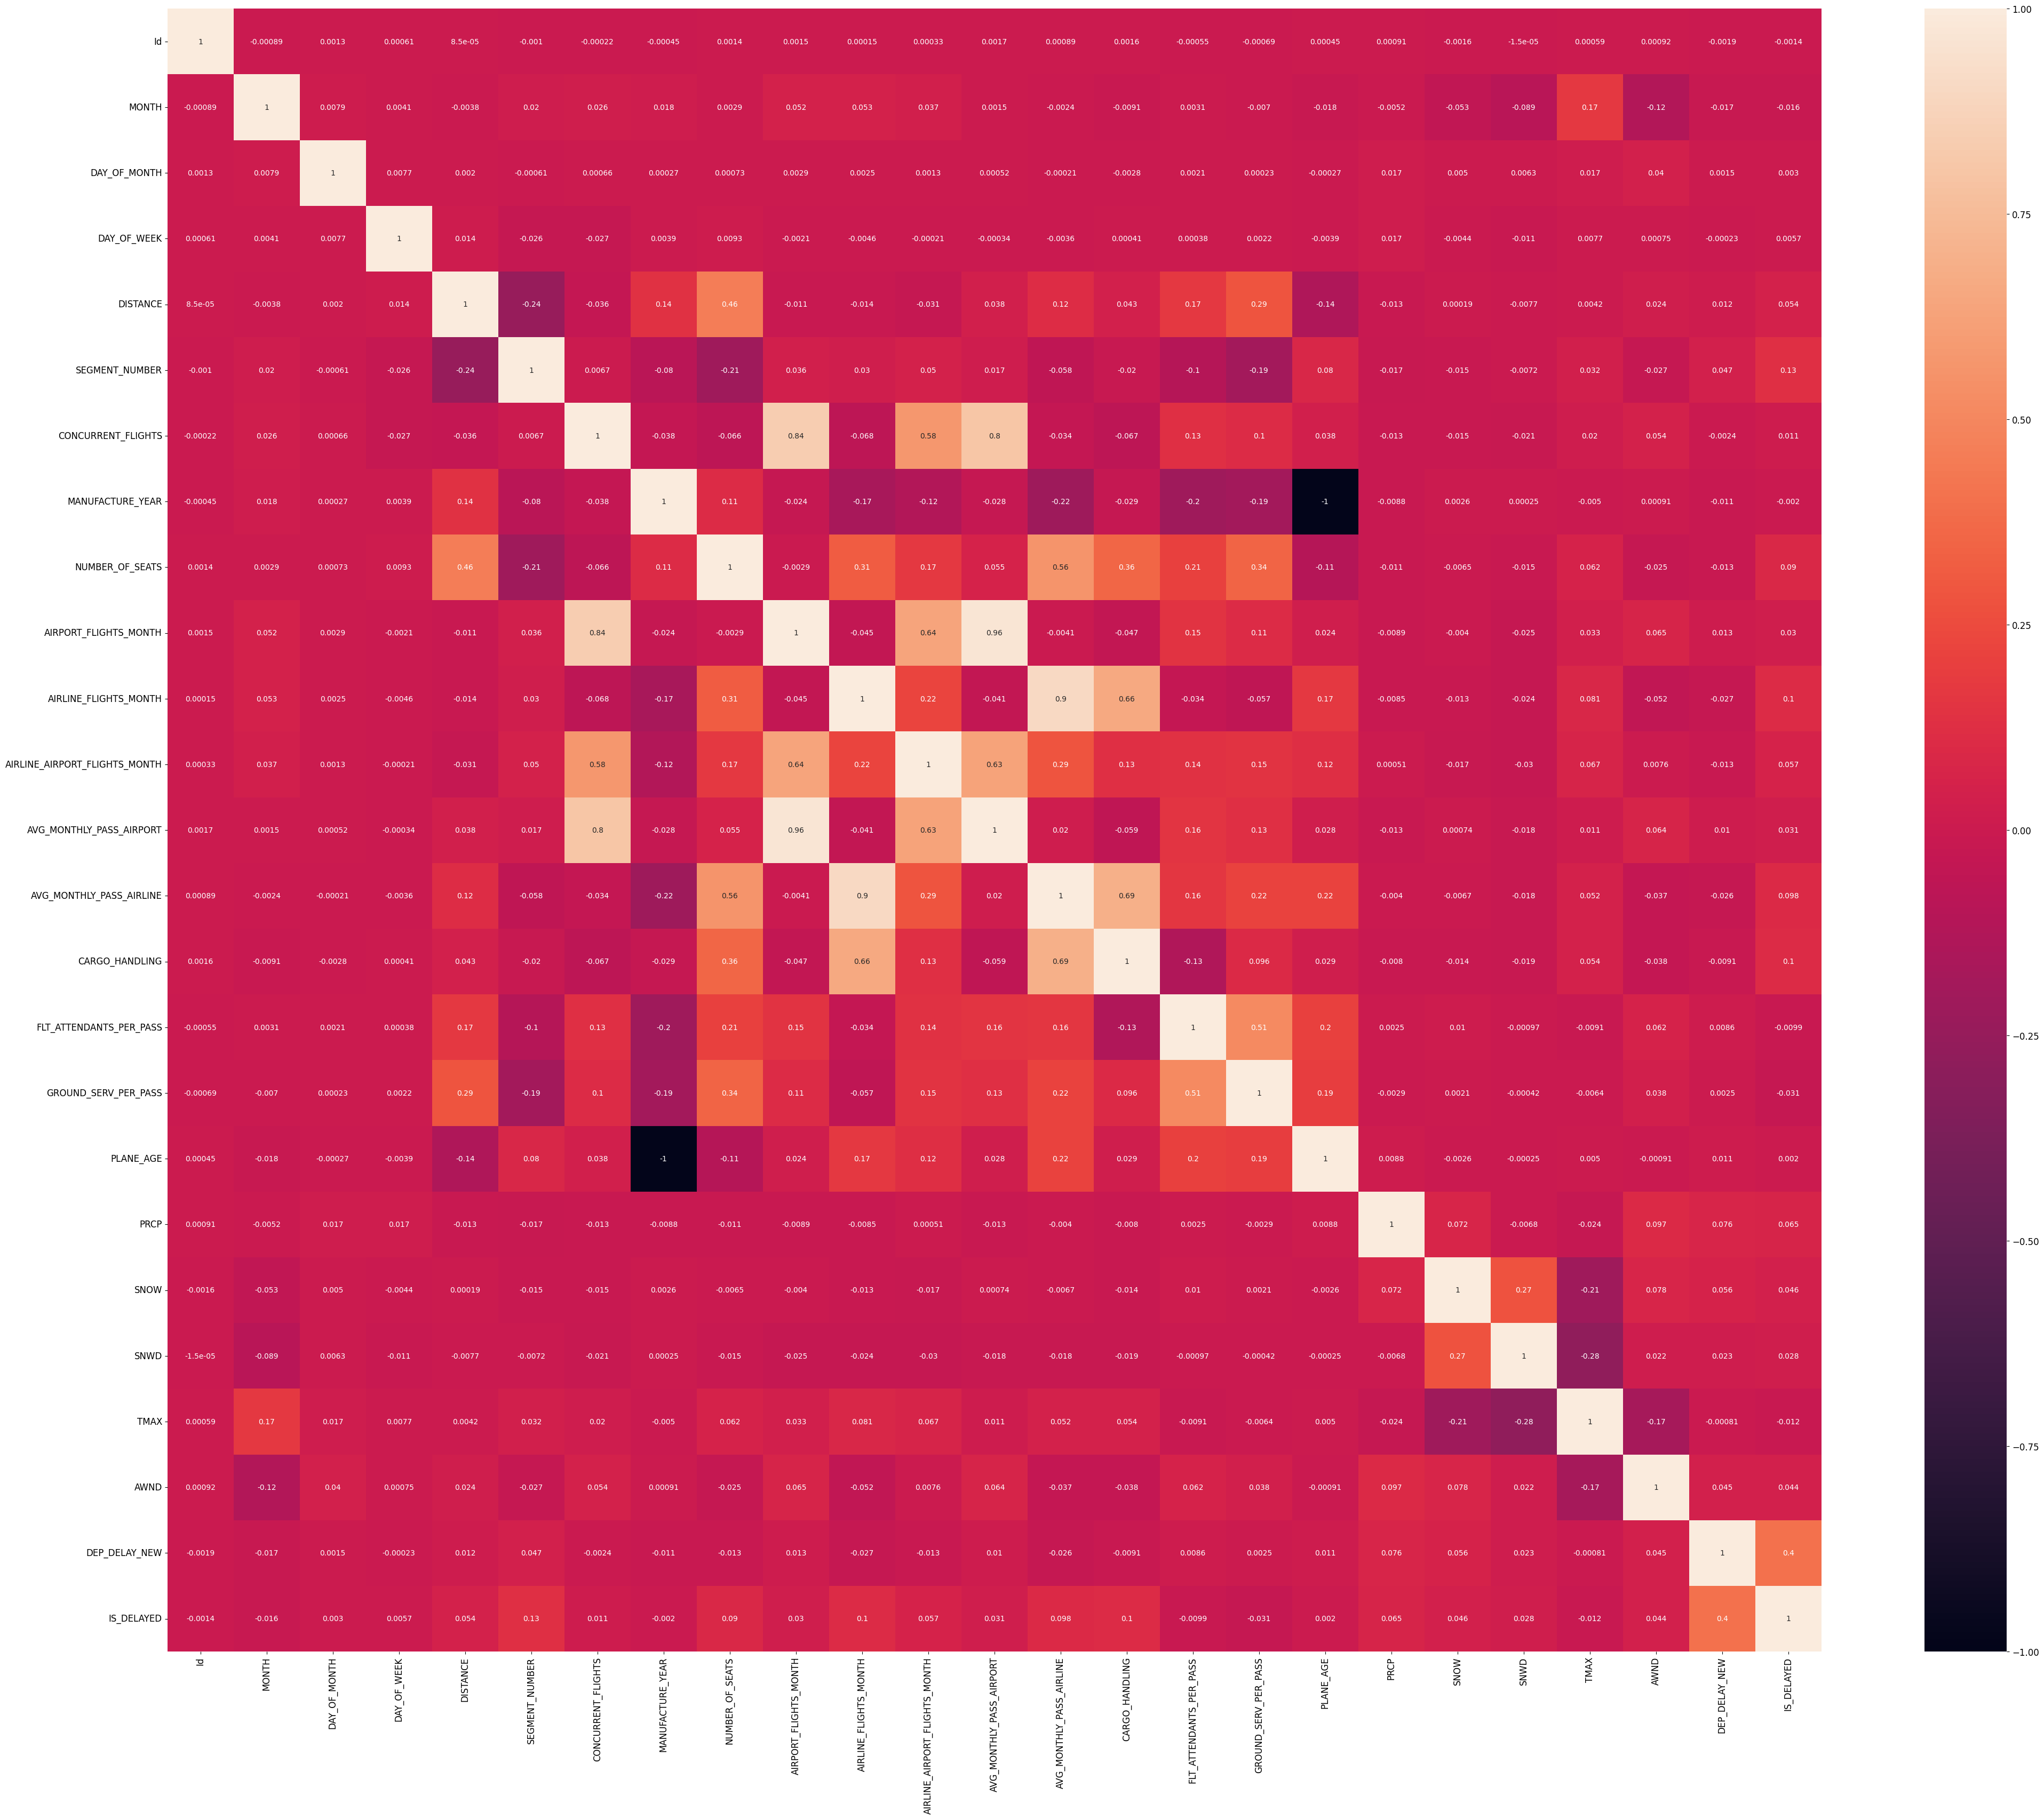

In [5]:
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(50, 40))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

## Prepare Dataset

### Remove Redundant Features

In [ ]:
df.head()

,Id,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEPARTING_AIRPORT,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,DEP_TIME_BLK,DISTANCE,...,GROUND_SERV_PER_PASS,PLANE_AGE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,DEP_DELAY_NEW,IS_DELAYED
0,0,1,17,4,Raleigh-Durham International,"Raleigh/Durham, NC",JFK,"New York, NY",1800-1859,427,...,0.000094,5,Ronald Reagan Washington National,0.01,0.0,0.0,49.0,4.70,2.0,1
1,1,2,27,3,San Jose International,"San Jose, CA",BOS,"Boston, MA",2200-2259,2689,...,0.000127,17,John F. Kennedy International,0.21,0.0,0.0,64.0,12.75,0.0,0
2,2,8,14,3,Los Angeles International,"Los Angeles, CA",ATL,"Atlanta, GA",0600-0659,1947,...,0.000149,23,NONE,0.00,0.0,0.0,74.0,8.50,0.0,0
3,3,3,16,6,Newark Liberty International,"Newark, NJ",DTW,"Detroit, MI",1400-1459,488,...,0.000124,4,Dallas Fort Worth Regional,0.00,0.0,0.0,56.0,17.67,0.0,0
4,4,6,20,4,Douglas Municipal,"Charlotte, NC",JFK,"New York, NY",1500-1559,541,...,0.000177,21,Myrtle Beach International,0.19,0.0,0.0,89.0,9.17,79.0,1


In [ ]:
df.drop(['Id', 'DEPARTING_AIRPORT', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME', 'MANUFACTURE_YEAR', 'PREVIOUS_AIRPORT', 'DEP_DELAY_NEW'], axis=1, inplace=True)

In [ ]:
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,CARGO_HANDLING,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,PRCP,SNOW,SNWD,TMAX,AWND,IS_DELAYED
0,1,17,4,1800-1859,427,6,13,76,Endeavor Air Inc.,4567,...,0,0.000000,0.000094,5,0.01,0.0,0.0,49.0,4.70,1
1,2,27,3,2200-2259,2689,2,3,162,JetBlue Airways,4249,...,62,0.000160,0.000127,17,0.21,0.0,0.0,64.0,12.75,0
2,8,14,3,0600-0659,1947,1,30,199,Delta Air Lines Inc.,19366,...,1462,0.000144,0.000149,23,0.00,0.0,0.0,74.0,8.50,0
3,3,16,6,1400-1459,488,3,23,76,"Midwest Airline, Inc.",10379,...,0,0.000001,0.000124,4,0.00,0.0,0.0,56.0,17.67,0
4,6,20,4,1500-1559,541,4,24,128,American Airlines Inc.,19017,...,16963,0.000098,0.000177,21,0.19,0.0,0.0,89.0,9.17,1


### One-Hot Encoding

In [ ]:
def is_busy_day(row):
    if row['MONTH'] == 1 and (1 <= row['DAY_OF_MONTH'] == 5):
        return 1  # New Year's Day
    elif row['MONTH'] == 11:  # November
        if row['DAY_OF_WEEK'] == 3 and row['DAY_OF_MONTH'] > 20 and row['DAY_OF_MONTH'] < 29:
            return 1  # Day before Thanksgiving
        if row['DAY_OF_WEEK'] == 7 and row['DAY_OF_MONTH'] > 22 and row['DAY_OF_MONTH'] < 31:
            return 1  # Sunday after Thanksgiving
        else:
            return 0
    elif row['MONTH'] == 12 and (21 <= row['DAY_OF_MONTH'] <= 31):
        return 1  # Christmas Eve and Day
    elif row['MONTH'] == 7 and (1 <= row['DAY_OF_MONTH'] == 7):
        return 1  # Independence Day
    elif row['MONTH'] == 3 and (row['DAY_OF_MONTH'] >= 15 and row['DAY_OF_MONTH'] <= 31):
        return 1  # Spring Break (simplified)
    elif row['MONTH'] == 5 and row['DAY_OF_MONTH'] >= 25:
        return 1  # Start of summer vacation
    elif row['MONTH'] == 6 and row['DAY_OF_MONTH'] <= 5:
        return 1  # Start of summer vacation
    elif row['MONTH'] == 9 and row['DAY_OF_WEEK'] == 1 and row['DAY_OF_MONTH'] < 8:
        return 1  # Labor Day (first Monday of September)
    else:
        return 0  # Not a busy day
def is_busy_time(time_blk):
    busy_times = ['0600-0659', '0700-0759', '0800-0859', '1700-1759', '1800-1859', '1900-1959']
    return int(time_blk in busy_times)


df['is_busy_time'] = df['DEP_TIME_BLK'].apply(is_busy_time)
df['is_busy_day'] = df.apply(is_busy_day, axis=1)
categorical_columns = df.select_dtypes(include=['object']).columns
columns_to_encode = list(categorical_columns) + ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK']
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

In [ ]:
df_encoded.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1400-1459,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359
0,427,6,13,76,4567,19709,398,573075,1212846,0,...,0,0,0,0,1,0,0,0,0,0
1,2689,2,3,162,4249,22053,99,614236,3190369,62,...,0,0,0,0,0,0,0,0,1,0
2,1947,1,30,199,19366,87457,3443,2780593,12460183,1462,...,0,0,0,0,0,0,0,0,0,0
3,488,3,23,76,10379,26929,1905,1708599,1529740,0,...,1,0,0,0,0,0,0,0,0,0
4,541,4,24,128,19017,76099,7752,2006675,11744595,16963,...,0,1,0,0,0,0,0,0,0,0


### Split

In [ ]:
# Taking 10% of the data to be workable
df_encoded_small = df_encoded.sample(frac=1, random_state=42)

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split

# X represents the features, and y represents the target variable
X = df_encoded_small.drop(['IS_DELAYED'], axis=1)
y = df_encoded_small['IS_DELAYED']

# First split: 10% for testing and 90% for temp (training + validation)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Second split: 10% for validation
X_train_imbalanced, X_val, y_train_imbalanced, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42)

In [ ]:
X_train_imbalanced.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1400-1459,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359
408019,337,2,45,143,17247,107978,3078,2780593,13382999,10955,...,0,0,0,0,0,0,0,0,0,0
129995,395,3,26,100,12236,23638,4500,1472200,3190369,62,...,0,0,0,0,0,0,0,0,0,0
637927,390,5,11,175,4439,106899,2506,525035,13382999,10955,...,0,0,0,0,0,0,1,0,0,0
291477,541,2,64,160,19734,80513,8157,2006675,11744595,16963,...,0,0,0,0,0,0,0,0,0,0
172225,942,1,36,150,13098,25270,4555,1472200,3190369,62,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train_imbalanced.head()

408019    1
129995    0
637927    0
291477    1
172225    0
Name: IS_DELAYED, dtype: int64

In [ ]:
y_train_imbalanced.value_counts()

0    335284
1    222501
Name: IS_DELAYED, dtype: int64

In [ ]:
# Check Proportion
num_rows_X_train_imbalanced = X_train_imbalanced.shape[0]
num_rows_X_test = X_val.shape[0]
X_prop = num_rows_X_train_imbalanced/num_rows_X_test

num_rows_y_train_imbalanced = y_train_imbalanced.shape[0]
num_rows_y_test = y_val.shape[0]
y_prop = num_rows_y_train_imbalanced/num_rows_y_test

print(f"X Proportion: {X_prop}")
print(f"y Proportion: {y_prop}")

X Proportion: 8.000817602845832
y Proportion: 8.000817602845832


### Balance

In [ ]:
# Assuming y_train_imbalanced and X_train_imbalanced are your original, imbalanced datasets

# Identify indices of the majority and minority classes
majority_indices = y_train_imbalanced[y_train_imbalanced == 0].index
minority_indices = y_train_imbalanced[y_train_imbalanced == 1].index

# Determine the number of instances you want for the majority class (same as minority class count)
minority_count = len(minority_indices)

# Randomly select indices from the majority class
downsampled_majority_indices = np.random.choice(majority_indices, minority_count, replace=False)

# Combine the downsampled majority class indices with the minority class indices
undersampled_indices = np.concatenate([downsampled_majority_indices, minority_indices])

# Use these indices to get the undersampled datasets
X_train = X_train_imbalanced.loc[undersampled_indices].sample(frac=1, random_state=42).reset_index(drop=True)
y_train = y_train_imbalanced.loc[undersampled_indices].sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
y_train.value_counts()

0    222501
1    222501
Name: IS_DELAYED, dtype: int64

## Models

### Linear Regression

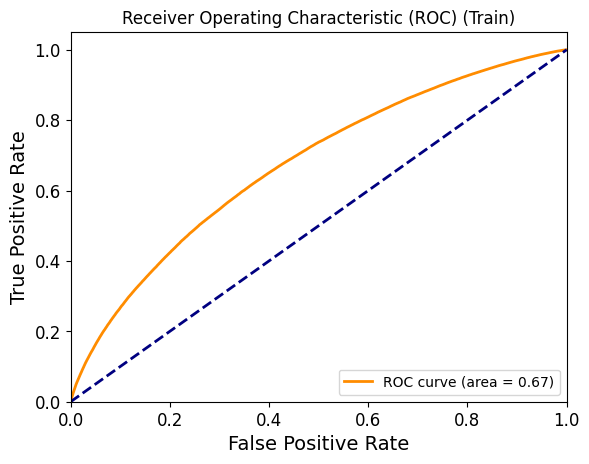

Area under the ROC Curve: 0.6736856667128823


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create a linear regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

# Predict the values using the training data
y_pred_continuous = linear_model.predict(X_train)

# Compute ROC curve and ROC area for each threshold
fpr, tpr, thresholds = roc_curve(y_train, y_pred_continuous)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) (Train)')
plt.legend(loc="lower right")
plt.show()

print(f"Area under the ROC Curve: {roc_auc}")

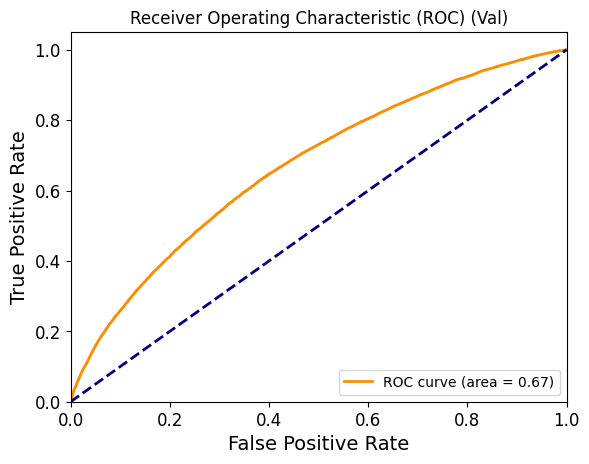

Area under the ROC Curve: 0.6689849639479962
Accuracy: 0.6210


In [ ]:
from sklearn.metrics import accuracy_score

# Predict the values using the training data
y_pred_continuous = linear_model.predict(X_val)

# Convert continuous predictions to binary using 0.5 as threshold
y_pred_binary = (y_pred_continuous > 0.5).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred_binary)

# Compute ROC curve and ROC area for each threshold
fpr, tpr, thresholds = roc_curve(y_val, y_pred_continuous)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) (Val)')
plt.legend(loc="lower right")
plt.show()

print(f"Area under the ROC Curve: {roc_auc}")
print(f"Accuracy: {accuracy:.4f}")  # Print accuracy with 4 decimal places

### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create an SVM with a polynomial kernel
svm_model = SVC(kernel='poly', degree=2, C=1.0, probability=True, random_state=42)

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Get decision function scores (continuous scores) using the training data
y_pred_continuous = svm_model.decision_function(X_train)

# Compute ROC curve and ROC area for each threshold
fpr, tpr, thresholds = roc_curve(y_train, y_pred_continuous)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"Area under the ROC Curve: {roc_auc}")

### Neural Network

Try adding predictions from linear model into data for neural network

In [ ]:
# Create X_train with linear model prediction
y_train_pred_continuous = linear_model.predict(X_train)
X_train_custom = X_train.copy()

# Add the predicted values to the new dataframe
X_train_custom['Predicted'] = y_train_pred_continuous

In [ ]:
# Create X_train with linear model prediction
y_val_pred_continuous = linear_model.predict(X_val)
X_val_custom = X_val.copy()

# Add the predicted values to the new dataframe
X_val_custom['Predicted'] = y_val_pred_continuous

In [ ]:
# Create X_train with linear model prediction
y_test_pred_continuous = linear_model.predict(X_test)
X_test_custom = X_test.copy()

# Add the predicted values to the new dataframe
X_test_custom['Predicted'] = y_test_pred_continuous

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform your data
X_train_custom_normalized = scaler.fit_transform(X_train_custom)

# Convert back to DataFrame for better readability (optional)
X_train_custom_normalized = pd.DataFrame(X_train_custom_normalized, columns=X_train_custom.columns)

X_train_custom_normalized.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359,Predicted
0,0.194090,-0.630477,-0.241386,0.455950,-0.188717,-1.272019,0.525644,0.312475,-1.056641,-0.726971,...,-0.257953,-0.249875,-0.266649,-0.253158,-0.250317,-0.243364,-0.193728,-0.181692,-0.090348,-0.291165
1,-0.818348,2.208758,2.382526,-0.546506,2.345389,0.507363,4.099515,2.483381,0.867434,-0.579145,...,-0.257953,-0.249875,-0.266649,-0.253158,-0.250317,-0.243364,5.161882,-0.181692,-0.090348,1.639452
2,0.004971,0.505217,1.492270,0.136017,1.040320,-0.383022,0.590734,1.018904,0.072055,-0.724508,...,-0.257953,-0.249875,3.750252,-0.253158,-0.250317,-0.243364,-0.193728,-0.181692,-0.090348,0.599496
3,-0.554234,1.640911,-0.475664,0.157346,0.037095,1.446776,0.684556,0.260666,1.052853,0.882640,...,-0.257953,-0.249875,-0.266649,-0.253158,-0.250317,4.109075,-0.193728,-0.181692,-0.090348,0.666572
4,-0.924320,-1.198324,0.180314,-1.271687,0.108556,-1.283745,-0.275528,-0.366800,-1.392458,-0.804272,...,-0.257953,-0.249875,-0.266649,-0.253158,-0.250317,-0.243364,-0.193728,-0.181692,-0.090348,-1.654811


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform your data
X_val_custom_normalized = scaler.fit_transform(X_val_custom)

# Convert back to DataFrame for better readability (optional)
X_val_custom_normalized = pd.DataFrame(X_val_custom_normalized, columns=X_val_custom.columns)

X_val_custom_normalized.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359,Predicted
0,-0.577071,-1.175289,1.546873,0.318983,0.174130,0.496799,-0.774004,-0.112551,0.741253,1.833714,...,-0.24984,-0.246256,-0.263367,-0.247792,-0.24336,-0.240703,-0.188616,-0.180555,-0.091831,-0.652317
1,-0.369737,0.531993,1.312141,-1.804521,1.187346,0.145907,0.266008,1.022918,-0.918209,-0.785269,...,-0.24984,-0.246256,-0.263367,-0.247792,-0.24336,4.154494,-0.188616,-0.180555,-0.091831,-0.325029
2,2.647208,-1.175289,0.091533,-0.700299,-0.218895,0.377599,-0.573206,0.063435,0.741253,1.833714,...,-0.24984,-0.246256,-0.263367,-0.247792,-0.24336,-0.240703,-0.188616,-0.180555,-0.091831,1.095893
3,-1.021123,1.101087,-1.035183,-1.252410,-1.353644,0.145907,-0.783712,-1.367221,-0.918209,-0.785269,...,-0.24984,-0.246256,3.796982,-0.247792,-0.24336,-0.240703,-0.188616,-0.180555,-0.091831,-0.551663
4,-0.851338,-0.037101,-1.035183,0.297748,-1.275232,0.450823,-0.803639,-1.281328,0.884815,-0.560957,...,-0.24984,-0.246256,-0.263367,-0.247792,-0.24336,-0.240703,-0.188616,-0.180555,-0.091831,-0.908152


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform your data
X_test_custom_normalized = scaler.fit_transform(X_test_custom)

# Convert back to DataFrame for better readability (optional)
X_test_custom_normalized = pd.DataFrame(X_test_custom_normalized, columns=X_test_custom.columns)

X_test_custom_normalized.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359,Predicted
0,-0.862062,2.234792,-1.083298,0.173055,-1.147389,1.508740,-0.391663,-1.215562,1.070008,0.907438,...,-0.254108,-0.2483,3.820275,-0.248788,-0.247485,-0.240490,-0.190312,-0.179484,-0.090789,1.324634
1,-0.360758,-0.038498,-0.567802,1.106502,-0.616051,0.497967,-0.748156,-0.199060,0.741079,1.835806,...,-0.254108,-0.2483,-0.261761,-0.248788,4.040642,-0.240490,-0.190312,-0.179484,-0.090789,0.559605
2,0.878621,1.098147,-0.239759,-0.548246,-0.190692,0.716241,-0.133888,0.061202,0.884742,-0.559439,...,-0.254108,-0.2483,-0.261761,4.019484,-0.247485,-0.240490,-0.190312,-0.179484,-0.090789,0.002363
3,1.587304,1.098147,-1.177025,0.809496,-0.913322,-0.312132,-0.730231,-0.729894,0.090016,-0.705307,...,-0.254108,-0.2483,-0.261761,-0.248788,-0.247485,-0.240490,-0.190312,-0.179484,11.014584,0.152753
4,1.009254,0.529825,1.822226,0.533705,1.307438,0.431195,2.156554,1.162951,0.741079,1.835806,...,-0.254108,-0.2483,-0.261761,-0.248788,-0.247485,4.158173,-0.190312,-0.179484,-0.090789,1.212394


Also need to normalize original data (without linear model predictions)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform your data
X_train_normalized = scaler.fit_transform(X_train)

# Convert back to DataFrame for better readability (optional)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)

X_train_normalized.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1400-1459,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359
0,0.194090,-0.630477,-0.241386,0.455950,-0.188717,-1.272019,0.525644,0.312475,-1.056641,-0.726971,...,-0.250783,-0.257953,-0.249875,-0.266649,-0.253158,-0.250317,-0.243364,-0.193728,-0.181692,-0.090348
1,-0.818348,2.208758,2.382526,-0.546506,2.345389,0.507363,4.099515,2.483381,0.867434,-0.579145,...,-0.250783,-0.257953,-0.249875,-0.266649,-0.253158,-0.250317,-0.243364,5.161882,-0.181692,-0.090348
2,0.004971,0.505217,1.492270,0.136017,1.040320,-0.383022,0.590734,1.018904,0.072055,-0.724508,...,-0.250783,-0.257953,-0.249875,3.750252,-0.253158,-0.250317,-0.243364,-0.193728,-0.181692,-0.090348
3,-0.554234,1.640911,-0.475664,0.157346,0.037095,1.446776,0.684556,0.260666,1.052853,0.882640,...,-0.250783,-0.257953,-0.249875,-0.266649,-0.253158,-0.250317,4.109075,-0.193728,-0.181692,-0.090348
4,-0.924320,-1.198324,0.180314,-1.271687,0.108556,-1.283745,-0.275528,-0.366800,-1.392458,-0.804272,...,-0.250783,-0.257953,-0.249875,-0.266649,-0.253158,-0.250317,-0.243364,-0.193728,-0.181692,-0.090348


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform your data
X_val_normalized = scaler.fit_transform(X_val)

# Convert back to DataFrame for better readability (optional)
X_val_normalized = pd.DataFrame(X_val_normalized, columns=X_val.columns)

X_val_normalized.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1400-1459,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359
0,-0.577071,-1.175289,1.546873,0.318983,0.174130,0.496799,-0.774004,-0.112551,0.741253,1.833714,...,-0.246583,-0.24984,-0.246256,-0.263367,-0.247792,-0.24336,-0.240703,-0.188616,-0.180555,-0.091831
1,-0.369737,0.531993,1.312141,-1.804521,1.187346,0.145907,0.266008,1.022918,-0.918209,-0.785269,...,-0.246583,-0.24984,-0.246256,-0.263367,-0.247792,-0.24336,4.154494,-0.188616,-0.180555,-0.091831
2,2.647208,-1.175289,0.091533,-0.700299,-0.218895,0.377599,-0.573206,0.063435,0.741253,1.833714,...,-0.246583,-0.24984,-0.246256,-0.263367,-0.247792,-0.24336,-0.240703,-0.188616,-0.180555,-0.091831
3,-1.021123,1.101087,-1.035183,-1.252410,-1.353644,0.145907,-0.783712,-1.367221,-0.918209,-0.785269,...,-0.246583,-0.24984,-0.246256,3.796982,-0.247792,-0.24336,-0.240703,-0.188616,-0.180555,-0.091831
4,-0.851338,-0.037101,-1.035183,0.297748,-1.275232,0.450823,-0.803639,-1.281328,0.884815,-0.560957,...,-0.246583,-0.24984,-0.246256,-0.263367,-0.247792,-0.24336,-0.240703,-0.188616,-0.180555,-0.091831


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform your data
X_test_normalized = scaler.fit_transform(X_test)

# Convert back to DataFrame for better readability (optional)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

X_test_normalized.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1400-1459,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359
0,-0.862062,2.234792,-1.083298,0.173055,-1.147389,1.508740,-0.391663,-1.215562,1.070008,0.907438,...,-0.244798,-0.254108,-0.2483,3.820275,-0.248788,-0.247485,-0.240490,-0.190312,-0.179484,-0.090789
1,-0.360758,-0.038498,-0.567802,1.106502,-0.616051,0.497967,-0.748156,-0.199060,0.741079,1.835806,...,-0.244798,-0.254108,-0.2483,-0.261761,-0.248788,4.040642,-0.240490,-0.190312,-0.179484,-0.090789
2,0.878621,1.098147,-0.239759,-0.548246,-0.190692,0.716241,-0.133888,0.061202,0.884742,-0.559439,...,-0.244798,-0.254108,-0.2483,-0.261761,4.019484,-0.247485,-0.240490,-0.190312,-0.179484,-0.090789
3,1.587304,1.098147,-1.177025,0.809496,-0.913322,-0.312132,-0.730231,-0.729894,0.090016,-0.705307,...,-0.244798,-0.254108,-0.2483,-0.261761,-0.248788,-0.247485,-0.240490,-0.190312,-0.179484,11.014584
4,1.009254,0.529825,1.822226,0.533705,1.307438,0.431195,2.156554,1.162951,0.741079,1.835806,...,-0.244798,-0.254108,-0.2483,-0.261761,-0.248788,-0.247485,4.158173,-0.190312,-0.179484,-0.090789


Now implement the neural net

Epoch 1/40
108/109 [============================>.] - ETA: 0s - loss: 0.6488 - accuracy: 0.6188
Epoch 1: val_loss improved from inf to 0.64510, saving model to best_weights.hdf5
109/109 [==============================] - 9s 76ms/step - loss: 0.6488 - accuracy: 0.6188 - val_loss: 0.6451 - val_accuracy: 0.6295
Epoch 2/40
  2/109 [..............................] - ETA: 7s - loss: 0.6419 - accuracy: 0.6306

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


109/109 [==============================] - ETA: 0s - loss: 0.6359 - accuracy: 0.6364
Epoch 2: val_loss improved from 0.64510 to 0.64253, saving model to best_weights.hdf5
109/109 [==============================] - 8s 72ms/step - loss: 0.6359 - accuracy: 0.6364 - val_loss: 0.6425 - val_accuracy: 0.6314
Epoch 3/40
108/109 [============================>.] - ETA: 0s - loss: 0.6304 - accuracy: 0.6428
Epoch 3: val_loss did not improve from 0.64253
109/109 [==============================] - 7s 65ms/step - loss: 0.6304 - accuracy: 0.6428 - val_loss: 0.6426 - val_accuracy: 0.6305
Epoch 4/40
108/109 [============================>.] - ETA: 0s - loss: 0.6263 - accuracy: 0.6474
Epoch 4: val_loss improved from 0.64253 to 0.63894, saving model to best_weights.hdf5
109/109 [==============================] - 8s 78ms/step - loss: 0.6263 - accuracy: 0.6474 - val_loss: 0.6389 - val_accuracy: 0.6363
Epoch 5/40
108/109 [============================>.] - ETA: 0s - loss: 0.6230 - accuracy: 0.6509
Epoch 5: val

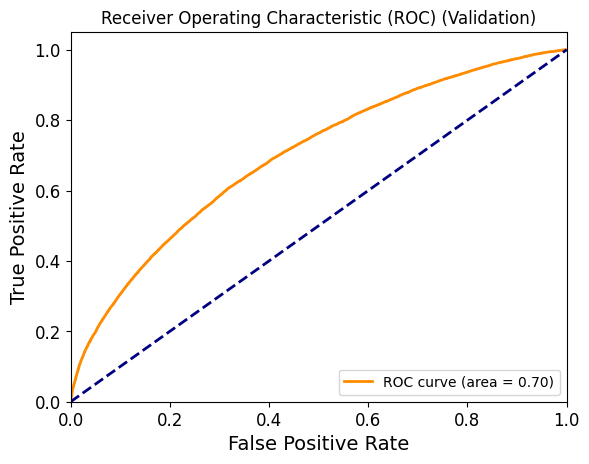

Area under the ROC Curve for Validation: 0.6981941169708584


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint  # <-- 1. Import ModelCheckpoint

# Define the neural network model
model = Sequential()
model.add(Dense(1024, input_dim=125, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0002)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Set up ModelCheckpoint callback  <-- 2. Set up ModelCheckpoint
checkpoint_filepath = 'best_weights.hdf5'
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')

# Fit the model to the training data and validate on validation data
history = model.fit(X_train_custom_normalized, y_train, epochs=40, batch_size=4096,
                    verbose=1, validation_data=(X_val_custom_normalized, y_val),
                    callbacks=[checkpoint])  # <-- 3. Add checkpoint callback to fit

# Load the best weights back into the model  <-- 4. Load the best weights
model.load_weights(checkpoint_filepath)

# Predict the values using the validation data
y_pred_continuous_val = model.predict(X_val_custom_normalized).ravel()

# Compute ROC curve and ROC area for each threshold for the validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_continuous_val)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curve for the validation set
plt.figure()
lw = 2
plt.plot(fpr_val, tpr_val, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) (Validation)')
plt.legend(loc="lower right")
plt.show()

print(f"Area under the ROC Curve for Validation: {roc_auc_val}")


2179/2179 [==============================] - 3s 1ms/step


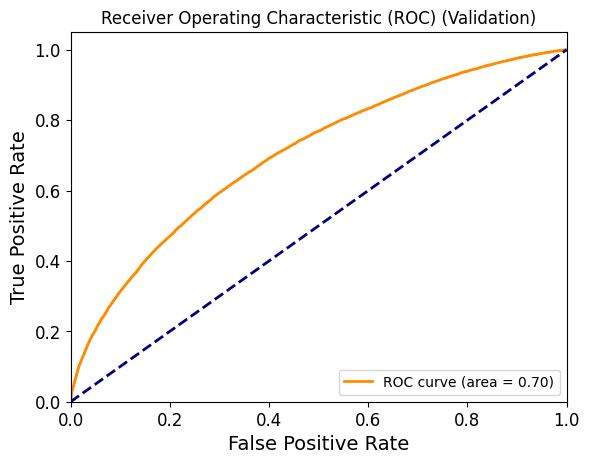

Area under the ROC Curve for Validation: 0.7025766407125271


In [ ]:
# Check performance on test set
y_pred_continuous_test = model.predict(X_test_custom_normalized).ravel()

# Compute ROC curve and ROC area for each threshold for the validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, y_pred_continuous_test)
roc_auc_test = auc(fpr_val, tpr_val)

# Plot ROC curve for the validation set
plt.figure()
lw = 2
plt.plot(fpr_val, tpr_val, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) (Validation)')
plt.legend(loc="lower right")
plt.show()

print(f"Area under the ROC Curve for Test: {roc_auc_test}")

# Try On Actual Test Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df_test = pd.read_csv('/content/drive/My Drive/Datathon/datathon_test.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_test_ids = df_test['Id']
df_test.drop(['Id', 'DEPARTING_AIRPORT', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME', 'MANUFACTURE_YEAR', 'PREVIOUS_AIRPORT'], axis=1, inplace=True)

In [ ]:
df_test.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,PRCP,SNOW,SNWD,TMAX,AWND
0,7,1,1,2000-2059,980,4,47,132,Delta Air Lines Inc.,14787,...,12460183,1462,0.000144,0.000149,18,0.0,0.0,0.0,93.0,4.70
1,4,12,5,1000-1059,1797,2,40,160,Delta Air Lines Inc.,17338,...,12460183,1462,0.000144,0.000149,18,0.0,0.0,0.0,73.0,12.30
2,10,11,5,0700-0759,298,2,23,50,Comair Inc.,11637,...,1245396,0,0.000000,0.000090,16,0.0,0.0,0.0,75.0,5.82
3,9,26,4,2000-2059,733,5,28,120,United Air Lines Inc.,13731,...,8501631,518,0.000254,0.000229,12,0.0,0.0,0.0,82.0,9.40
4,8,13,2,2000-2059,164,9,64,50,SkyWest Airlines Inc.,14439,...,3472966,10,0.000034,0.000099,16,0.0,0.0,0.0,88.0,7.61


In [ ]:
df_test['is_busy_time'] = df_test['DEP_TIME_BLK'].apply(is_busy_time)
df_test['is_busy_day'] = df_test.apply(is_busy_day, axis=1)
categorical_columns = df_test.select_dtypes(include=['object']).columns
columns_to_encode = list(categorical_columns) + ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK']
df_test_encoded = pd.get_dummies(df_test, columns=columns_to_encode)

In [ ]:
df_test_encoded.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1400-1459,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359
0,980,4,47,132,14787,86274,6606,1581456,12460183,1462,...,0,0,0,0,0,0,1,0,0,0
1,1797,2,40,160,17338,76299,2995,2780593,12460183,1462,...,0,0,0,0,0,0,0,0,0,0
2,298,2,23,50,11637,23411,2415,955406,1245396,0,...,0,0,0,0,0,0,0,0,0,0
3,733,5,28,120,13731,51182,740,1208249,8501631,518,...,0,0,0,0,0,0,1,0,0,0
4,164,9,64,50,14439,70841,4166,1486066,3472966,10,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Predict the values using the training data
y_pred_continuous = linear_model.predict(df_test_encoded)
print(y_pred_continuous)

[0.55394891 0.47162434 0.25905947 ... 0.55746972 0.38959631 0.45826185]


This extra if doing the custom neural network

In [ ]:
# Predict the values using the training data
y_pred_continuous = linear_model.predict(df_test_encoded)
df_custom = df_test_encoded.copy()

# Add the predicted values to the new dataframe
df_custom['Predicted'] = y_pred_continuous
df_custom.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359,Predicted
0,980,4,47,132,14787,86274,6606,1581456,12460183,1462,...,0,0,0,0,0,1,0,0,0,0.553949
1,1797,2,40,160,17338,76299,2995,2780593,12460183,1462,...,0,0,0,0,0,0,0,0,0,0.471624
2,298,2,23,50,11637,23411,2415,955406,1245396,0,...,0,0,0,0,0,0,0,0,0,0.259059
3,733,5,28,120,13731,51182,740,1208249,8501631,518,...,0,0,0,0,0,1,0,0,0,0.397097
4,164,9,64,50,14439,70841,4166,1486066,3472966,10,...,0,0,0,0,0,1,0,0,0,0.455322


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform your data
df_custom_normalized = scaler.fit_transform(df_custom)

# Convert back to DataFrame for better readability (optional)
df_custom_normalized = pd.DataFrame(df_custom_normalized, columns=df_custom.columns)

df_custom_normalized.head()

,DISTANCE,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,CARGO_HANDLING,...,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359,Predicted
0,0.206014,0.530240,0.893490,-0.058386,0.291476,0.678635,0.813624,-0.020299,0.886029,-0.560309,...,-0.253629,-0.245495,-0.262065,-0.248408,-0.244289,4.188641,-0.190196,-0.178871,-0.090058,0.418381
1,1.537595,-0.603701,0.564568,0.537498,0.599126,0.382804,-0.107455,1.063340,0.886029,-0.560309,...,-0.253629,-0.245495,-0.262065,-0.248408,-0.244289,-0.238741,-0.190196,-0.178871,-0.090058,-0.127751
2,-0.905538,-0.603701,-0.234242,-1.803477,-0.088414,-1.185712,-0.255398,-0.586049,-1.363876,-0.786499,...,-0.253629,-0.245495,-0.262065,-0.248408,-0.244289,-0.238741,-0.190196,-0.178871,-0.090058,-1.537884
3,-0.196557,1.097211,0.000702,-0.313766,0.164122,-0.362099,-0.682650,-0.357560,0.091866,-0.706358,...,-0.253629,-0.245495,-0.262065,-0.248408,-0.244289,4.188641,-0.190196,-0.178871,-0.090058,-0.622160
4,-1.123937,3.365093,1.692299,-1.803477,0.249507,0.220934,0.191239,-0.106501,-0.916982,-0.784952,...,-0.253629,-0.245495,-0.262065,-0.248408,-0.244289,4.188641,-0.190196,-0.178871,-0.090058,-0.235899


In [ ]:
# Predict the values using the training data
y_pred_continuous = model.predict(df_custom_normalized)
print(y_pred_continuous)

9338/9338 [==============================] - 15s 2ms/step
[[0.5611474 ]
 [0.5235869 ]
 [0.36135674]
 ...
 [0.6170942 ]
 [0.1941586 ]
 [0.4227518 ]]


Save in format to submit to test against actual the competition test data that we can't see:

In [ ]:
# Create a new DataFrame with required format
output = pd.DataFrame({
    'Id': df_test_ids,
    'IS_DELAYED': y_pred_continuous
})

# Write to CSV
output.to_csv('submission.csv', index=False)

In [ ]:
# Flatten the predictions to ensure they are 1-dimensional
y_pred_continuous_flat = y_pred_continuous.flatten()

# Create a new DataFrame with required format
output = pd.DataFrame({
    'Id': df_test_ids,
    'IS_DELAYED': y_pred_continuous_flat
})

# Write to CSV
output.to_csv('submission.csv', index=False)


Best Score: 0.701523